In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy

from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfd=tfp.distributions

In [93]:
def draw(base, position = None, ax = None,R = 100):
    ## function to plot the geometry
    if ax == None:
        f,ax=plt.subplots()
        
    if position is not None:

        t = tf.convert_to_tensor(thickness,dtype = tf.float32)

        ps2 = position-t
        
        ps2 = tf.reverse(ps2,[-1])
        
        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],position[i-Number_para-6]])

    x = base[:,0]
    z = base[:,1]
    for i in range(base.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')
    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)
    
    
pi = tf.constant(m.pi) # define PI in Tensorflow form

In [94]:
def draw_MCMC(base,samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
    
    if Truth is not None:
        draw(base,Truth,ax = ax, R = R)
            
    x1 = np.linspace(-R,R,Number_para)

    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    for ps in samples:
        ps2 = ps-t

        ps2 = tf.reverse(ps2,[-1])

        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],ps[i-Number_para-6]])

        for i in range(Number_para+5,base.shape[0]-2):
            ax.plot(base[:,0][i:i+2],base[:,1][i:i+2],'r-',alpha = 0.01)
    
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface

    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)

In [95]:
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
Number_para = 6
obs_N = 6
points = np.empty((2*Number_para+8,2),dtype = np.float32)

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[Number_para+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(21)

x2 = np.linspace(-70,70,Number_para+2)
x1 = np.linspace(70,-70,Number_para+2)
## here, maybe change to normal distribution
y1 = np.random.uniform(-2,-50,Number_para)
y2 = y1-thickness

y1 = list(reversed(y1))

for i in range(2,Number_para+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(Number_para+6,2*Number_para+6): ## upper layer
    points[i][1] = y1[i-Number_para-6]
    points[i][0] = x1[i-Number_para-5]


(-70, 70)

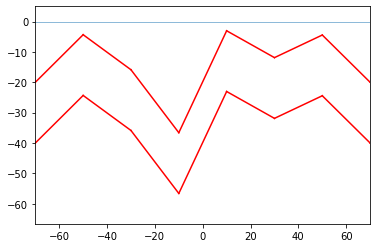

In [96]:
# Draw Base
f,ax=plt.subplots()
x = points[:,0]
z = points[:,1]
for i in range(points.shape[0]):
    ax.plot(x[i:i+2],z[i:i+2],'r-')
x_ = np.linspace(-70,70,10)
ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
ax.set_ylim(min(points[:,1])-10,5)
ax.set_xlim(-70,70)

In [97]:
# prior
mu_prior = -20.*tf.ones([Number_para],dtype = tf.float32)
cov_prior = 20.*tf.eye(Number_para)

# likelihood
sig_e = 0.0000001
cov = sig_e**2*tf.eye(obs_N)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [98]:
@tf.function
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

@tf.function
def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

@tf.function
def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)

@tf.function
def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))

@tf.function
def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)

@tf.function
def g(x,z,loc):

    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)

@tf.function
def grav(x,z):

    thick = thickness

    x_obv = tf.linspace(tf.constant(-70.),tf.constant(70.),obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float32)
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float32, size=obv.shape[0])

    j = tf.constant(0)
    for i in obv:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return tf.reshape(gravity.stack(),shape = [obs_N])



@tf.function
def joint_log_prob(D,x,z):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood
    
    Gm_ = grav(x,z)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    print('tracing')
    tf.print('excuting')
    
    # return the posterior probability
    return(mvn_prior.log_prob(z[Number_para+6:2*Number_para+6])
          +mvn_likelihood.log_prob(D))


In [99]:
True_position = tf.random.uniform([Number_para],-30,-1,seed = 10)

In [100]:
True_position = True_position + tf.random.normal(True_position.shape)

In [101]:
x = tf.convert_to_tensor(x,dtype = tf.float32)
z = tf.convert_to_tensor(z,dtype = tf.float32)

In [102]:


thick = thickness

x_obv = tf.linspace(tf.constant(-70.),tf.constant(70.),obs_N)
y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float32)
obv = tf.stack((x_obv,y_obv),axis = 1)

gravity = tf.TensorArray(tf.float32, size=obv.shape[0])

j = tf.constant(0)
for i in obv:
    gravity=gravity.write(j,-g(x,z,i))
    j = tf.add(j,1)
tf.reshape(gravity.stack(),shape = [obs_N])


<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([7.5246116e-06, 8.4140675e-06, 6.6648308e-06, 8.8453899e-06,
       8.8389697e-06, 7.4164113e-06], dtype=float32)>

In [103]:
D = grav(x,z)

In [104]:
z+tf.ones_like(z)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-39.       , -39.       , -23.338795 , -34.877262 , -55.606384 ,
       -22.03758  , -30.884293 , -23.437117 , -39.       , -39.       ,
       -19.       , -19.       ,  -3.4371161, -10.884293 ,  -2.03758  ,
       -35.606384 , -14.877264 ,  -3.3387942, -19.       , -19.       ],
      dtype=float32)>

In [105]:
%load_ext tensorboard
from datetime import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [106]:
!rm -rf ./logs/ 

In [107]:
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [108]:
tf.summary.trace_on(graph=True, profiler=True)

In [109]:
posterior = joint_log_prob(D,x,z)

tracing
excuting


In [110]:
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

In [111]:
%tensorboard --logdir logs/func

Reusing TensorBoard on port 6006 (pid 33754), started 4:50:20 ago. (Use '!kill 33754' to kill it.)

In [25]:
joint_log_prob(D,x,z)
joint_log_prob(D,x,z)
joint_log_prob(D,x,z)
joint_log_prob(D,x,z)

excuting
excuting
excuting
excuting


<tf.Tensor: shape=(), dtype=float32, numpy=48.34826>

In [17]:
x.shape[0]

20

In [18]:
def g(x,z,loc):

    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)



In [19]:
def g_new(x,z,loc):
    
    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = tf.TensorArray(tf.float32, size=_x.shape[0])

    for i in tf.range(_x.shape[0]-1):
        Z_sum = Z_sum.write(i, Z(_x,_z,i,i+1))
    Z_sum = Z_sum.write(_x.shape[0]-1,Z(_x,_z,-1,0))
    a = Z_sum.stack()
    g = 2*G*rho *tf.reduce_sum(a)
    return(g)

In [20]:
tf.negative(joint_log_prob(D,x,z,mu))

NameError: name 'mu' is not defined

In [ ]:
z = tf.convert_to_tensor(z,dtype = tf.float32)

In [ ]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = tf.negative(joint_log_prob(D,x,z,mu))
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = t.gradient(jac,z,unconnected_gradients = 'none')

In [ ]:
hess

In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float32, size=Number_para)
    j=0
    for i in range(Number_para+6,2*Number_para+6):
        print(j)
        with tf.GradientTape() as t:
            with tf.GradientTape() as tt:
                tt.watch(z)
                loss = tf.negative(joint_log_prob(D,x,z,mu))
            jac = tt.gradient(loss,z,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,z,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return (Hess.stack()[:,Number_para+6:2*Number_para+6])

In [ ]:
Hess = Full_Hessian()

In [ ]:
Hess

## Decorating with tf.function

In [ ]:
@tf.function
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

@tf.function
def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

@tf.function
def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)

@tf.function(experimental_relax_shapes=True)
def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))

@tf.function
def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)

@tf.function
def g(x,z,loc):

#     G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
#     rho = tf.constant(1000.)        # density difference   kg/m^3

#     _x = x-loc[0]
#     _z = z-loc[1]

    Z_sum = tf.constant(0.)

    for i in tf.range(x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(x,z,i,i+1))

#     Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

#     g = 2*G*rho * Z_sum

    return(Z_sum)

@tf.function
def g_while(x,z,loc):

    Z_sum = tf.constant(0.)

    for i in tf.range(x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(x,z,i,i+1))


    return(Z_sum)


In [ ]:
x.shape[0]-1

In [ ]:

def g_while(x,z):
    i = tf.constant(0)
    Z_sum = tf.constant(0.)
    c = lambda i,Z_sum: tf.less(i, 5)
    def body(i,Z_sum):
        i = i + 1
        Z_sum = tf.add(Z_sum, Z(x,z,i,i+1))
        return i,Z_sum
    _,Z_sum = tf.while_loop(c, body, loop_vars=[i,Z_sum])
    print( 'Tracing!')
    tf.print( 'Executing!')
    return Z_sum

def jacobian():
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = g_while(x,z)
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
    print( 'jac Tracing!')
    tf.print( 'jac Executing!')
    return jac
jacobian()
jacobian()

In [ ]:
@tf.function
def g_while(x,z):
    i = tf.constant(0)
    Z_sum = tf.constant(0.)
    c = lambda i,Z_sum: tf.less(i, 5)
    def body(i,Z_sum):
        i = i + 1
        Z_sum = tf.add(Z_sum, Z(x,z,i,i+1))
        return i,Z_sum
    _,Z_sum = tf.while_loop(c, body, loop_vars=[i,Z_sum])
    print( 'Tracing!')
    tf.print( 'Executing!')
    return Z_sum

In [ ]:
@tf.function
def jacobian():
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = g_while(x,z)
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
    print( 'jac Tracing!')
    tf.print( 'jac Executing!')
    return jac
jacobian()
jacobian()

In [ ]:
g_while(x,z)

In [ ]:

def H():
    with tf.GradientTape() as t:
        t.watch(z)
        with tf.GradientTape() as tt:
            tt.watch(z)
            loss = g_while(x,z)
        jac = tt.gradient(loss,z,unconnected_gradients='zero')
    hess = t.gradient(jac,z,unconnected_gradients = 'none')

    return hess

In [ ]:
H()

In [ ]:
g_while(x,z,tf.constant([0,0],dtype = tf.float32))

In [ ]:
g(x,z,tf.constant([0,0],dtype = tf.float32))

In [ ]:
Z(x,z,tf.constant(1),tf.constant(1))

In [ ]:
loc = tf.constant([0,0],dtype = tf.float32)

In [ ]:
with tf.GradientTape() as t:
    t.watch(z)
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = g(x,z,loc)
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = t.gradient(jac,z,unconnected_gradients = 'none')

In [ ]:
hess

In [ ]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = tf.negative(joint_log_prob(D,x,z,mu))
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = t.jacobian(jac,z,unconnected_gradients = 'none')
print(hess)

In [ ]:
HessMatrix = np.empty(shape = [Number_para,Number_para])
for x1,i1 in enumerate(range(Number_para+6,2*Number_para+6)):
    for y1,i2 in enumerate(range(Number_para+6,2*Number_para+6)):
        HessMatrix[x1,y1] = hess[i1,i2]

Define the Prior and likelihood distribution

In [ ]:
points = tf.Variable(points,dtype = tf.float32)

In [ ]:
# define the ground truth
tf.random.set_seed(1234)
tf.random.uniform([Number_para])
True_position = tf.random.uniform([Number_para],-30,-1,seed = 10)
x = tf.Variable(points[:,0])
z = tf.Variable(points[:,1])
obs_data = grav(x,z,True_position)

In [ ]:
D = obs_data

In [ ]:
D

#### create some noise

In [ ]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =0,stddev =sig_e,seed = 1)

In [ ]:
D_noise = D+noise

In [ ]:
joint_log_prob(D,x,z,True_position)

In [ ]:
def grav_calculate(_x,_z,x_obs=None, R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(_x,_z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
    ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

In [ ]:
D_noise

In [ ]:
points

In [ ]:
True_position

In [ ]:
draw(points,True_position,R = 70)

In [ ]:
grav_calculate(x,z,x_obs = tf.linspace(-70., 70.,500),R = 70)

In [ ]:
True_position

#### Gradient decent

In [ ]:
mu = tf.random.uniform([Number_para],minval = -20,maxval = -2,seed = 1) # initial parameters

In [ ]:
mu

In [ ]:
joint_log_prob(D,x,z,True_position)

In [ ]:
with tf.GradientTape() as t:  
    t.watch(z)
    loss = joint_log_prob(D_noise,x,z,mu) # negative log posterior
dlossdmu = t.gradient(loss,z)

In [ ]:
print(dlossdmu)

In [ ]:
f,ax = plt.subplots()
ax.plot(D,'r')
ax.plot(D_noise)
ax.set_ylim(4e-6,10e-6)

In [ ]:
for i in range(100):
    with tf.GradientTape() as t:  
        t.watch(z)
        loss = tf.negative(joint_log_prob(D,x,z,mu)) # negative log posterior
        dlossdmu = t.gradient(loss,z)
        print('loss =',loss)
        print('grad =',dlossdmu)
    mu = mu-0.01*dlossdmu[Number_para+6:2*Number_para+6]
#     print(mu)
    print('Iteration:',i)

In [ ]:
joint_log_prob(D,x,z,mu)

In [ ]:
joint_log_prob(D,x,z,True_position)